In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [67]:
laptop = pd.read_csv('laptop_preprocessed.csv')
laptop.head(3)

,Company,TypeName,Cpu,Ram,Weight,Price,Touchscreen,IPS,ppi,HDD,SSD,Gpu brand,OS
0,Apple,Ultrabook,Intel Core i5,8,1.37,71378.6832,No,Yes,226.983005,0,128,Intel,Mac
1,Apple,Ultrabook,Intel Core i5,8,1.34,47895.5232,No,No,127.677940,0,0,Intel,Mac
2,HP,Notebook,Intel Core i5,8,1.86,30636.0000,No,No,141.211998,0,256,Intel,Other OS


In [68]:
x = laptop.drop(columns=['Price'])
y = np.log(laptop.Price)

In [69]:
x

,Company,TypeName,Cpu,Ram,Weight,Touchscreen,IPS,ppi,HDD,SSD,Gpu brand,OS
0,Apple,Ultrabook,Intel Core i5,8,1.37,No,Yes,226.983005,0,128,Intel,Mac
1,Apple,Ultrabook,Intel Core i5,8,1.34,No,No,127.677940,0,0,Intel,Mac
2,HP,Notebook,Intel Core i5,8,1.86,No,No,141.211998,0,256,Intel,Other OS
3,Apple,Ultrabook,Intel Core i7,16,1.83,No,Yes,220.534624,0,512,AMD,Mac
4,Apple,Ultrabook,Intel Core i5,8,1.37,No,Yes,226.983005,0,256,Intel,Mac
...,...,...,...,...,...,...,...,...,...,...,...,...
1297,Lenovo,2 in 1 Convertible,Intel Core i7,4,1.80,Yes,Yes,157.350512,0,128,Intel,Windows
1298,Lenovo,2 in 1 Convertible,Intel Core i7,16,1.30,Yes,Yes,276.053530,0,512,Intel,Windows
1299,Lenovo,Notebook,Other Intel Processor,2,1.50,No,No,111.935204,0,0,Intel,Windows
1300,HP,Notebook,Intel Core i7,6,2.19,No,No,100.454670,1000,0,AMD,Windows


In [70]:
y

0       11.175755
1       10.776777
2       10.329931
3       11.814476
4       11.473101
          ...    
1297    10.433899
1298    11.288115
1299     9.409283
1300    10.614129
1301     9.886358
Name: Price, Length: 1302, dtype: float64

In [71]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

transform = ColumnTransformer(transformers=[
    ('encode', OneHotEncoder(sparse=False, drop='first'), [0,1,2,5,6,10,11])
], remainder='passthrough')

x = transform.fit_transform(x)

In [72]:
# Train Test Split
from sklearn.model_selection import train_test_split as tts
x_train, x_test, y_train, y_test = tts(x, y, test_size=0.1, random_state=0)

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor

from sklearn.metrics import r2_score,mean_absolute_error

In [74]:
lin = LinearRegression()
knn = KNeighborsRegressor()
svr = SVR()
tree = DecisionTreeRegressor(random_state=0)
bag = BaggingRegressor(DecisionTreeRegressor(random_state=0), random_state=0)
forest = RandomForestRegressor(random_state=0)
grad = GradientBoostingRegressor(random_state=0)
ada = AdaBoostRegressor(DecisionTreeRegressor(random_state=0),random_state=0)
vote = VotingRegressor(estimators=[('l',lin), ('k',knn), ('s',svr)])

In [75]:
z = np.empty(9)
l = 0
for i in (lin, knn, svr, tree, bag, forest, grad, ada, vote):
    i.fit(x_train,y_train)
    y_pred = i.predict(x_test)

    z[l] = r2_score(y_test, y_pred)
    l=l+1

In [76]:
z

array([0.77106863, 0.72577488, 0.60684981, 0.6841781 , 0.81235689,
       0.83916558, 0.82840481, 0.82559968, 0.7798234 ])

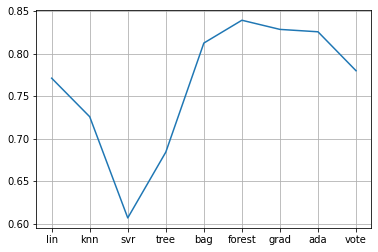

In [77]:
pd.Series(z, index=('lin', 'knn', 'svr', 'tree', 'bag', 'forest', 'grad', 'ada', 'vote')).plot(grid=True);

Here, we can see Bagging, Random Forest, GradientBoost and AdaBoost models gives us high r2_scores.

So, we will tune parameters of this 4 models to get much better r2_score.

# Bagging parameter tunning

In [78]:
Z = np.empty(30)
l = 0
for i in np.arange(20,620,20):
    bag = BaggingRegressor(DecisionTreeRegressor(random_state=0), random_state=0, n_estimators = i, n_jobs=-1)
    bag.fit(x_train, y_train)
    y_pred = bag.predict(x_test)

    Z[l] = r2_score(y_test, y_pred)
    l = l+1

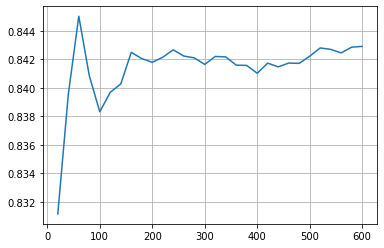

In [79]:
pd.Series(Z, index=np.arange(20,620,20)).plot(grid= True);

In [80]:
Z

array([0.83115774, 0.83952894, 0.84502025, 0.84085454, 0.83832189,
       0.83968548, 0.84027003, 0.84248865, 0.84205026, 0.84178862,
       0.84214535, 0.84266444, 0.84223064, 0.8421022 , 0.84164213,
       0.84219923, 0.84217072, 0.84158932, 0.84157269, 0.84102159,
       0.84173143, 0.84146984, 0.84173781, 0.84171532, 0.84221431,
       0.84279747, 0.84269775, 0.84244945, 0.84285192, 0.84290403])

So, Bagging Regressor gives max r2_score at n_estimators = 60.

In [81]:
bag = BaggingRegressor(DecisionTreeRegressor(random_state=0), random_state=0, n_estimators = 60, n_jobs=-1)
bag.fit(x_train, y_train)
y_pred = bag.predict(x_test)

print('R2 : ', r2_score(y_test, y_pred))
print('MAE : ', mean_absolute_error(y_test, y_pred))

R2 :  0.8450202459382845
MAE :  0.17478140471068623


# Random Forest parameter tunning

In [82]:
Z = np.empty(90)
l = 0
for i in np.arange(20,320,20):
    for j in (2,5,8,10,12,15):
        forest = RandomForestRegressor(random_state=0, n_estimators = i, max_depth = j, n_jobs=-1)
        forest.fit(x_train, y_train)
        y_pred = forest.predict(x_test)

        Z[l] = r2_score(y_test, y_pred)
        l = l+1

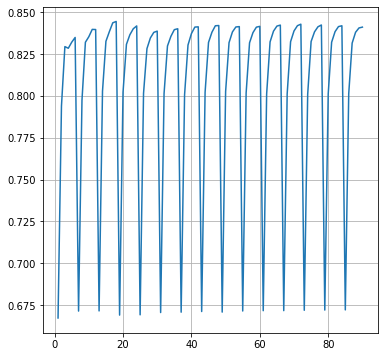

In [83]:
plt.figure(figsize=[6,6])
pd.Series(Z, index=np.arange(1,91)).plot(grid= True);

In [84]:
Z = np.empty(6)
l = 0
for i in (2,5,8,10,12,15):
    forest = RandomForestRegressor(random_state=0, n_estimators = 60, max_depth = i, n_jobs=-1)
    forest.fit(x_train, y_train)
    y_pred = forest.predict(x_test)

    Z[l] = r2_score(y_test, y_pred)
    l = l+1

In [85]:
Z

array([0.67143126, 0.80281301, 0.83265835, 0.83839743, 0.84371479,
       0.84452346])

So, Random Forest Regressor gives max r2_score at n_estimators = 60 and max_depth = 15.

In [86]:
forest = RandomForestRegressor(random_state=0, n_estimators = 60, max_depth = 15, n_jobs=-1)
forest.fit(x_train, y_train)
y_pred = forest.predict(x_test)

print('R2 : ', r2_score(y_test, y_pred))
print('MAE : ', mean_absolute_error(y_test, y_pred))

R2 :  0.8445234625920306
MAE :  0.1764094418518891


# AdaBoost Regressor parameter tunning

In [87]:
Z = np.empty(105)
l = 0
for i in np.arange(20,320,20):
    for j in np.arange(0.1,0.8,0.1):
        ada = AdaBoostRegressor(DecisionTreeRegressor(random_state=0), n_estimators = i, learning_rate = j, random_state=0)
        ada.fit(x_train, y_train)
        y_pred = ada.predict(x_test)

        Z[l] = r2_score(y_test, y_pred)
        l = l+1

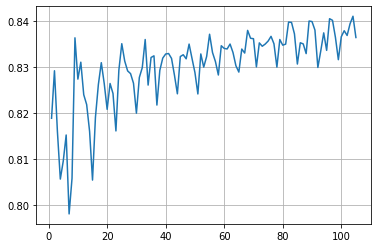

In [88]:
pd.Series(Z, index=np.arange(1,106)).plot(grid= True);

In [89]:
Z = np.empty(7)
l = 0
for i in np.arange(0.1,0.8,0.1):
    ada = AdaBoostRegressor(DecisionTreeRegressor(random_state=0), n_estimators = 300, learning_rate = i, random_state=0)
    ada.fit(x_train, y_train)
    y_pred = ada.predict(x_test)

    Z[l] = r2_score(y_test, y_pred)
    l = l+1

In [90]:
Z

array([0.83158088, 0.83655563, 0.83787513, 0.8368417 , 0.83938284,
       0.84101916, 0.83639718])

So, AdaBoost Regressor gives max r2_score at n_estimators = 300 and learning_rate = 0.6.

In [91]:
ada = AdaBoostRegressor(DecisionTreeRegressor(random_state=0), n_estimators = 300, learning_rate = 0.6, random_state=0)
ada.fit(x_train, y_train)
y_pred = ada.predict(x_test)

print('R2 : ', r2_score(y_test, y_pred))
print('MAE : ', mean_absolute_error(y_test, y_pred))

R2 :  0.8410191624418603
MAE :  0.18481687099529495


# GradientBoost Regressor parameter tunning

In [92]:
Z = np.empty(108)
l = 0
for i in np.arange(50,350,50):
    for j in np.arange(0.1,0.7,0.1):
        for k in (5,10,15):  
            grad = GradientBoostingRegressor(random_state=0, n_estimators = i, learning_rate = j, max_depth = k)
            grad.fit(x_train, y_train)
            y_pred = grad.predict(x_test)

            Z[l] = r2_score(y_test, y_pred)
            l = l+1

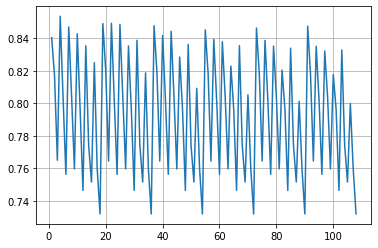

In [93]:
pd.Series(Z, index=np.arange(1,109)).plot(grid= True);

In [94]:
Z = np.empty(18)
l = 0
for i in np.arange(0.1,0.7,0.1):
    for j in (5,10,15):  
        grad = GradientBoostingRegressor(random_state=0, n_estimators = 50, learning_rate = i, max_depth = j)
        grad.fit(x_train, y_train)
        y_pred = grad.predict(x_test)

        Z[l] = r2_score(y_test, y_pred)
        l = l+1

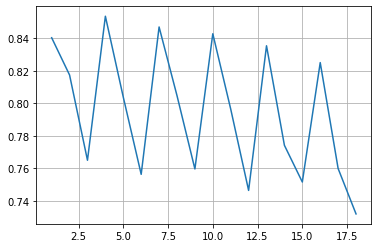

In [95]:
pd.Series(Z, index=np.arange(1,19)).plot(grid= True);

In [96]:
Z = np.empty(3)
l = 0
for i in (5,10,15):  
    grad = GradientBoostingRegressor(random_state=0, n_estimators = 50, learning_rate = 0.2, max_depth = i)
    grad.fit(x_train, y_train)
    y_pred = grad.predict(x_test)

    Z[l] = r2_score(y_test, y_pred)
    l = l+1

In [97]:
Z

array([0.85356522, 0.80375911, 0.7562266 ])

So, Gradient Boost Regressor gives max r2_score at n_estimators = 50, learning_rate = 0.2 and max_depth = 5

In [98]:
grad_model = GradientBoostingRegressor(random_state=0, n_estimators = 50, learning_rate = 0.2, max_depth = 5)
grad_model.fit(x_train, y_train)
y_pred = grad_model.predict(x_test)

print('R2 : ', r2_score(y_test, y_pred))
print('MAE : ', mean_absolute_error(y_test, y_pred))

R2 :  0.8535652154833921
MAE :  0.1741314843221777


# GradientBoost Model gives maximum r2_score and minimun mean_absolute_error, after parameter tunning. So, I will use this model.

In [99]:
laptop

,Company,TypeName,Cpu,Ram,Weight,Price,Touchscreen,IPS,ppi,HDD,SSD,Gpu brand,OS
0,Apple,Ultrabook,Intel Core i5,8,1.37,71378.6832,No,Yes,226.983005,0,128,Intel,Mac
1,Apple,Ultrabook,Intel Core i5,8,1.34,47895.5232,No,No,127.677940,0,0,Intel,Mac
2,HP,Notebook,Intel Core i5,8,1.86,30636.0000,No,No,141.211998,0,256,Intel,Other OS
3,Apple,Ultrabook,Intel Core i7,16,1.83,135195.3360,No,Yes,220.534624,0,512,AMD,Mac
4,Apple,Ultrabook,Intel Core i5,8,1.37,96095.8080,No,Yes,226.983005,0,256,Intel,Mac
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,Lenovo,2 in 1 Convertible,Intel Core i7,4,1.80,33992.6400,Yes,Yes,157.350512,0,128,Intel,Windows
1298,Lenovo,2 in 1 Convertible,Intel Core i7,16,1.30,79866.7200,Yes,Yes,276.053530,0,512,Intel,Windows
1299,Lenovo,Notebook,Other Intel Processor,2,1.50,12201.1200,No,No,111.935204,0,0,Intel,Windows
1300,HP,Notebook,Intel Core i7,6,2.19,40705.9200,No,No,100.454670,1000,0,AMD,Windows


In [100]:
x = laptop.drop(columns=['Price'])
y = np.log(laptop.Price)

In [101]:
x_train, x_test, y_train, y_test = tts(x, y, test_size=0.1, random_state=0)

In [102]:
from sklearn.pipeline import Pipeline

step1 = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(sparse=False, drop='first'), [0,1,2,5,6,10,11])
],remainder='passthrough')

step2 = GradientBoostingRegressor(learning_rate=0.2, max_depth=5, n_estimators=50, random_state=0)

pipe = Pipeline([
    ('step1',step1),
    ('step2',step2)
])

pipe.fit(x,y)

y_pred = pipe.predict(x_test)

print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

R2 score 0.9413512210122441
MAE 0.1114436323334201


In [103]:
import pickle

pickle.dump(laptop,open('laptop_preprocessed.pkl','wb'))
pickle.dump(pipe,open('pipe.pkl','wb'))